<a href="https://colab.research.google.com/github/aliabdari/compressed-QA/blob/main/QA_compressed_domain.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [985]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [986]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from tensorflow import keras
from keras.models import Sequential
from keras.layers import BatchNormalization
from keras.layers import Activation
from keras.layers import Dropout
from keras.layers import Dense
from keras.layers import Input
from keras.models import Model
from tensorflow.keras.optimizers import Adam
from keras.regularizers import l2

In [987]:
x_temp = np.load('/content/drive/MyDrive/information_live/x_vgg16.npy',allow_pickle= True)

In [988]:
x_temp.shape[0]

160

In [989]:
x_temp2 = np.empty(150,dtype=object)

In [990]:
idx = 0
for i in range(x_temp.shape[0]):
  if i % 16 == 0:
    continue
  x_temp2[idx] = x_temp[i]
  idx+=1

In [991]:
x_temp2.shape

(150,)

## Load DOM

In [992]:
y_temp = np.loadtxt('/content/drive/MyDrive/live_dataset_Reconstructed_Residuals/live_video_quality_data.txt')

In [993]:
y_temp.shape

(150, 2)

In [994]:
y = y_temp[:,0]

In [995]:
y = np.asarray(y).astype('float32')

In [996]:
max_y = np.max(y)

In [997]:
y=y/max_y

## POT

In [998]:
np.mean(x_temp2[10], axis=1).shape

(4096,)

In [999]:
x = np.empty((150,4096),dtype=object)
for i in range(x_temp2.shape[0]):
  x[i,:] = np.mean(x_temp2[i], axis=1)
  pass

In [1000]:
x.shape

(150, 4096)

In [1001]:
x = np.asarray(x).astype('float32')

In [1002]:
np.max(x)

4.789821

In [1003]:
x = x/np.max(x)

# Data preparation

In [1004]:
x_test = x[0:30,:].copy()
y_test = y[0:30].copy()

In [1005]:
x_test.shape

(30, 4096)

In [1006]:
x_train = x[30:,:].copy()
y_train = y[30:].copy()

In [1007]:
x_train.shape

(120, 4096)

In [1008]:
def do_shuffle(X,Y,number_of_data):
  shuffle_index = np.arange(number_of_data)
  np.random.shuffle(shuffle_index)
  return X[shuffle_index],Y[shuffle_index]

In [1009]:
x_train,y_train = do_shuffle(x_train,y_train,120)

In [1010]:
x_train.dtype

dtype('float32')

## Model

In [1011]:
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.08, shuffle= True)

In [1012]:
model = Sequential()
model.add(Dense(32, activation="relu"))
model.add(BatchNormalization())
model.add(Dropout(0.25))
model.add(Dense(16, activation="relu"))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(8,activation="linear"))
model.add(BatchNormalization())
model.add(Dropout(0.05))
model.add(Dense(4,activation="linear"))
model.add(Dense(1, activation="linear"))


callbacks = [
    keras.callbacks.ModelCheckpoint("QA_compressed.h5", save_best_only=True),
		keras.callbacks.EarlyStopping(monitor='val_loss', patience=30)
]

opt = Adam(learning_rate=1e-3, decay=1e-3 / 200)
model.compile(loss="mean_squared_error", optimizer=opt)

history = model.fit(x=x_train, y=y_train, 
	validation_data=(x_valid, y_valid),
	epochs=500, 
	batch_size=64)

Epoch 1/500
2/2 [==============================] - 1s 158ms/step - loss: 5.2801 - val_loss: 2.9007
Epoch 2/500
2/2 [==============================] - 0s 23ms/step - loss: 3.4554 - val_loss: 2.7906
Epoch 3/500
2/2 [==============================] - 0s 26ms/step - loss: 3.1910 - val_loss: 2.7264
Epoch 4/500
2/2 [==============================] - 0s 42ms/step - loss: 3.3063 - val_loss: 2.4822
Epoch 5/500
2/2 [==============================] - 0s 29ms/step - loss: 2.8402 - val_loss: 2.3192
Epoch 6/500
2/2 [==============================] - 0s 43ms/step - loss: 2.2428 - val_loss: 2.3739
Epoch 7/500
2/2 [==============================] - 0s 23ms/step - loss: 3.1896 - val_loss: 2.3578
Epoch 8/500
2/2 [==============================] - 0s 23ms/step - loss: 2.3274 - val_loss: 2.3258
Epoch 9/500
2/2 [==============================] - 0s 23ms/step - loss: 2.2734 - val_loss: 2.3400
Epoch 10/500
2/2 [==============================] - 0s 23ms/step - loss: 2.0812 - val_loss: 2.2116
Epoch 11/500
2/2 [

## Plot

In [1013]:
def plot_diagrams_trian_process(history):
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.plot(history['loss'])
    plt.plot(history['val_loss'])
    plt.legend(['loss','val_loss'])

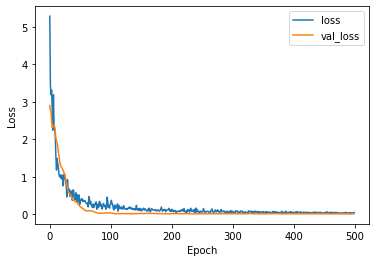

In [1014]:
plot_diagrams_trian_process(history.history)

##Predict

In [1015]:
y_test_predict = model.predict(x_test)
y_test_predict *= max_y

In [1016]:
y_test_orig = y_test * max_y

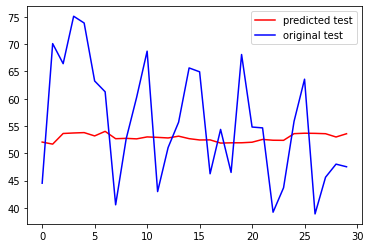

In [1017]:
plt.plot(y_test_predict, label = 'predicted test' ,color = 'red')
plt.plot(y_test_orig, label = 'original test' ,color = 'blue')
plt.legend()

## Spearman correlation

In [1018]:
np.squeeze(y_test_predict, axis=1).shape

(30,)

In [1019]:
np.corrcoef(y_test_orig, np.squeeze(y_test_predict, axis=1))

array([[1.        , 0.17384482],
       [0.17384482, 1.        ]])

In [1020]:
from scipy import stats
rho, pval = stats.spearmanr(np.squeeze(y_test_predict, axis=1), y_test_orig)

In [1021]:
rho

0.21690767519466073

## Train Data evaluation

In [1022]:
y_train_predict = model.predict(x_train)
y_train_predict *= max_y
y_train_orig = y_train * max_y

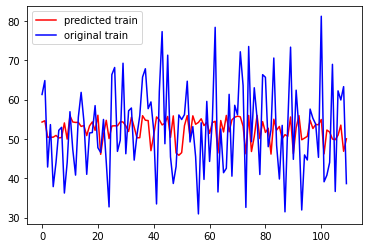

In [1023]:
plt.plot(y_train_predict, label = 'predicted train' ,color = 'red')
plt.plot(y_train_orig, label = 'original train' ,color = 'blue')
plt.legend()